# Notebook to setup the radcalnet_oc package

In [2]:

import os, shutil
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
rc = {"font.family": "serif",
      "mathtext.fontset": "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

plt.rcParams.update({'font.size': 18, 'axes.labelsize': 22})
import numpy as np
import xarray as xr
import pandas as pd

import radcalnet_oc as radoc
from radcalnet_oc import acutils
print(f'-radcalnet_oc: {radoc.__version__}')


-radcalnet_oc: 0.0.1


In [3]:
central_wl = np.arange(350, 2500, 1)

lut= radoc.LUT(wl=central_wl)
lut.load_auxiliary_data()


In [4]:

fwhm=3

szas=[30,45,60]
vza=0
lut.lut_preparation(sza=szas,vza=[vza])
szas = lut.Rdiff_lut.sza
mu0 = np.cos(np.radians(szas))
# tcwv cm into kg.m-2
tpw_cm=2.6
tcwv=tpw_cm*10 

to3_du=300 
pressure=1000

# conversion O3 du to kg.m-2
tco3=to3_du *6.4286e-3/300
tcno2=3e-6/100
tcch4= 1e-2

# set total transmittance values
gas_trans = radoc.GaseousTransmittance(lut.gas_lut)
gas_trans.pressure=pressure
gas_trans.gas_tc['h2o'] = tcwv
gas_trans.gas_tc['o3'] = tco3
gas_trans.gas_tc['ch4'] = tcch4
gas_trans.air_mass=1./np.cos(np.radians(szas))+1./np.cos(np.radians(vza))

gas_trans.coef_abs_scat['h2o'] = 1
gas_trans.coef_abs_scat['ch4'] = 1
Ttot=gas_trans.get_gaseous_transmittance()

# signal convolution on spectral responses
signal=Ttot
wl_signal = signal.wl.values
spectral=radoc.Spectral(central_wl,fwhm)
Tg = spectral.convolve(signal,name='Ttot')

# get solar irradiance
solar_irr=radoc.SolarIrradiance()
signal = solar_irr.tsis
F0 = spectral.convolve(signal)*mu0

# get top-of-atmosphere reflectance or radiance
Rtoa=Tg*lut.Rdiff_lut.squeeze()
Ltoa=Rtoa*F0/np.pi


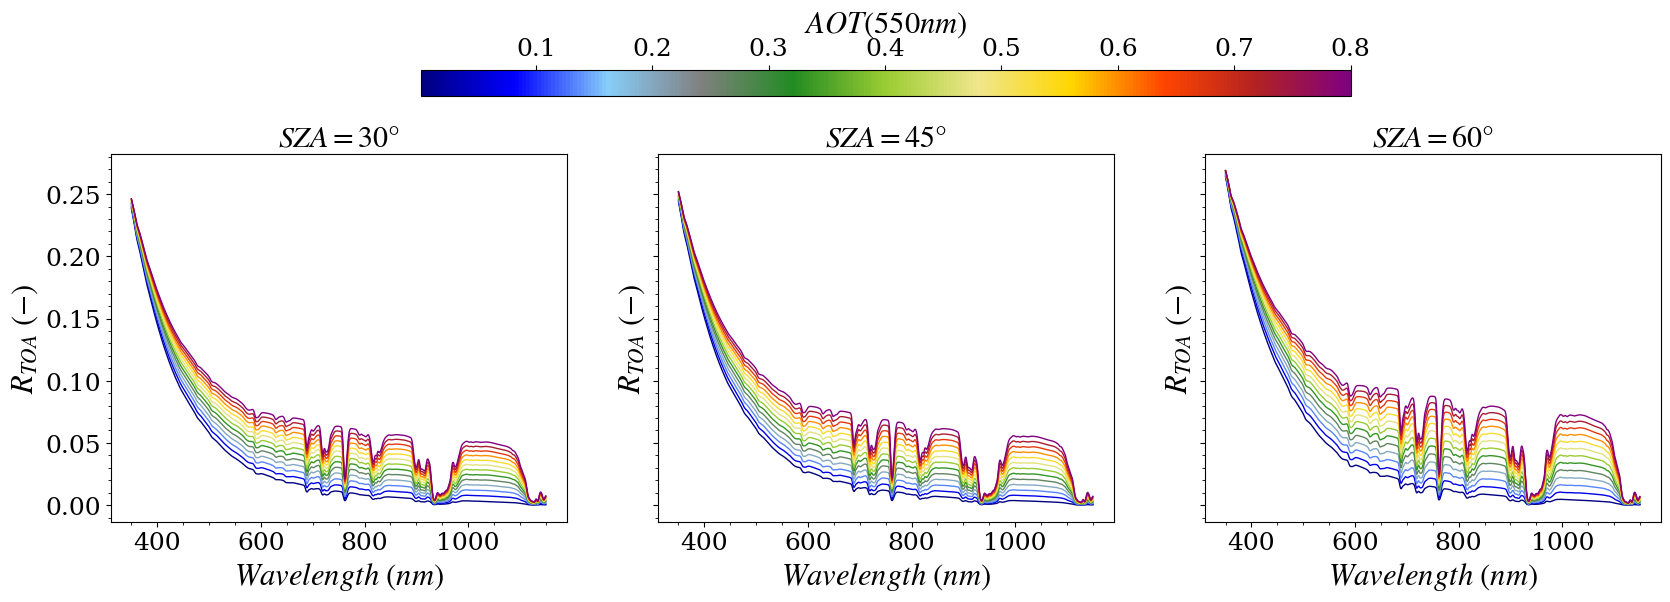

In [5]:

wl_range=slice(350,1150)
cmap = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['navy', "blue", 'lightskyblue',
                                                     "grey",   'forestgreen','yellowgreen',
                                                     "khaki", "gold",
                                                     'orangered', "firebrick", 'purple'])
norm = mpl.colors.Normalize(vmin=0.001,vmax=0.8)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig,axs = plt.subplots(1,3,figsize=(20,6.5),sharey=True)
axs=axs.ravel()

for isza, sza in enumerate(Rtoa.sza.values):
    ax=axs[isza]
    for aot_ref in Rtoa.aot_ref.values[::2]:
        Rtoa_=Rtoa.sel(sza=sza,aot_ref=aot_ref).sel(wl=wl_range) #+ Tabs*Ttot*  np.pi * Rrs
        #Rsim.sel(aot_ref=aot_ref).plot(x='wl',color=cmap(norm(aot_ref)),add_legend=False,ls=':',lw=1,ax=axs[i_])
        Rtoa_.plot(x='wl',color=cmap(norm(aot_ref)),lw=1,ax=ax)
      
    ax.set_title(r'$SZA='+str(sza)+r'\degree$')
    ax.set_ylabel(r'$R_{TOA}\ (-)$')
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.minorticks_on()

cb = fig.colorbar(sm, ax=axs[:], shrink=0.6, aspect=35, pad=0.115, location='top')
cb.set_label(r'$AOT(550nm)$', fontsize=22)

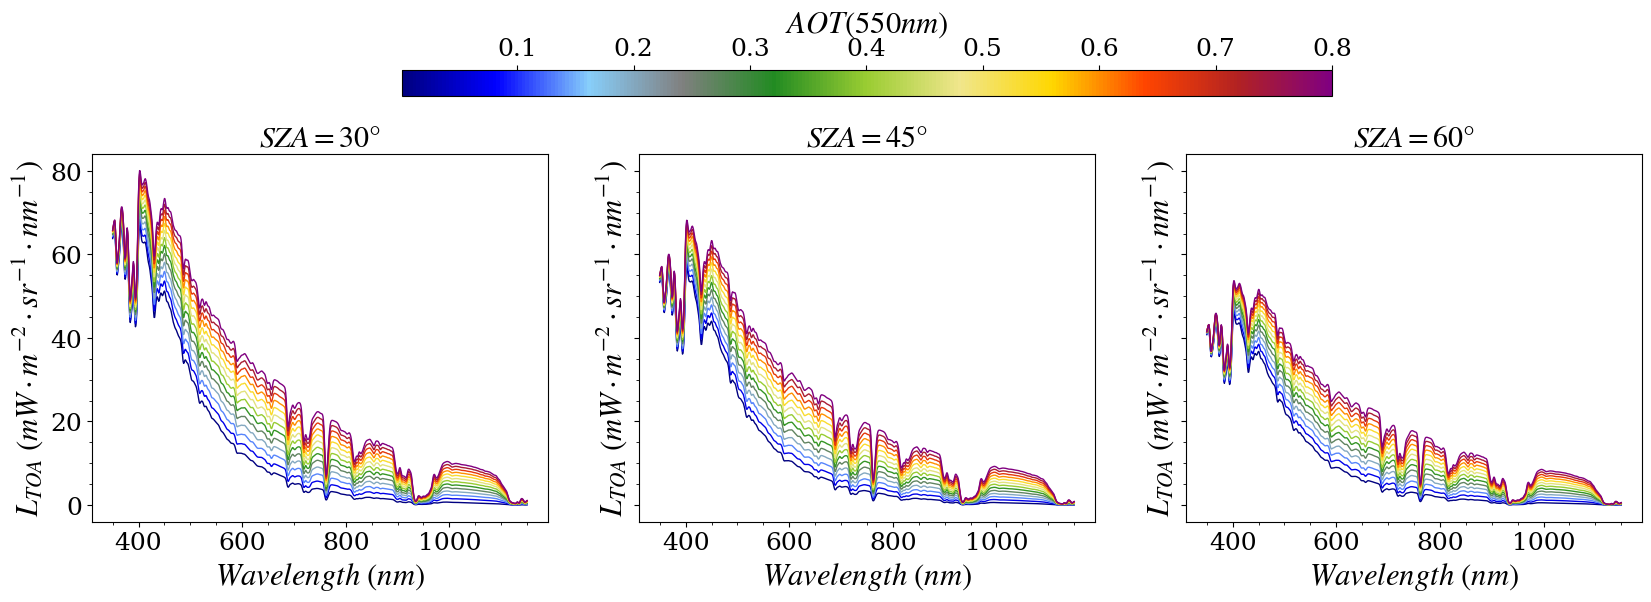

In [6]:



cmap = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['navy', "blue", 'lightskyblue',
                                                     "grey",   'forestgreen','yellowgreen',
                                                     "khaki", "gold",
                                                     'orangered', "firebrick", 'purple'])

norm = mpl.colors.Normalize(vmin=0.001,vmax=0.8)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

sm.set_array([])
fig,axs = plt.subplots(1,3,figsize=(20,6.5),sharey=True)
axs=axs.ravel()

for isza, sza in enumerate(Rtoa.sza.values):
    ax=axs[isza]
    for aot_ref in Rtoa.aot_ref.values[::2]:
        Ltoa_=Ltoa.sel(sza=sza,aot_ref=aot_ref).sel(wl=wl_range) #+ Tabs*Ttot*  np.pi * Rrs
        #Rsim.sel(aot_ref=aot_ref).plot(x='wl',color=cmap(norm(aot_ref)),add_legend=False,ls=':',lw=1,ax=axs[i_])
        Ltoa_.plot(x='wl',color=cmap(norm(aot_ref)),lw=1,ax=ax)
    ax.set_title(r'$SZA='+str(sza)+r'\degree$')
    ax.set_ylabel(r'$L_{TOA}\ (mW\cdot m^{-2}\cdot sr^{-1}\cdot nm^{-1})$')
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.minorticks_on()

cb = fig.colorbar(sm, ax=axs[:], shrink=0.6, aspect=35, pad=0.115, location='top')
cb.set_label(r'$AOT(550nm)$', fontsize=22)

## Check wind speed impact

In [11]:
lut= radoc.LUT(wl=central_wl)
lut.lut_preparation(wind=2,
                    sza=szas,
                    vza=[0],
                    azi=[0],
                    aot_refs=np.linspace(0.0, 0.8, 25),
                    weights=[0, 0.5, 1, 0., 0.])
lut2= radoc.LUT(wl=central_wl)
lut2.lut_preparation(wind=6,
                    sza=szas,
                    vza=[0],
                    azi=[0],
                    aot_refs=np.linspace(0.0, 0.8, 25),
                    weights=[0, 0.5, 1, 0., 0.])



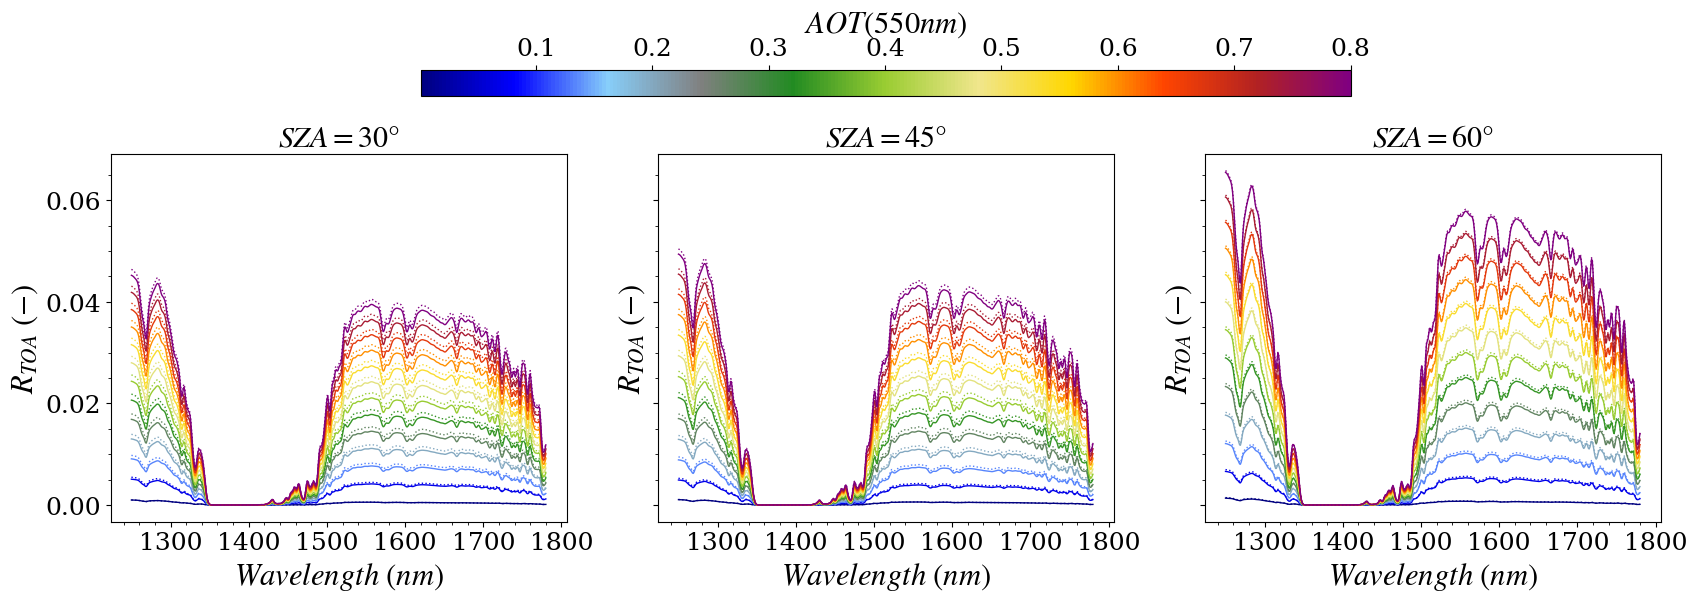

In [14]:


Rtoa=Tg*lut.Rdiff_lut.squeeze()
Rtoa2=Tg*lut2.Rdiff_lut.squeeze()
wl_range=slice(1250,1780)
cmap = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['navy', "blue", 'lightskyblue',
                                                     "grey",   'forestgreen','yellowgreen',
                                                     "khaki", "gold",
                                                     'orangered', "firebrick", 'purple'])
norm = mpl.colors.Normalize(vmin=0.001,vmax=0.8)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig,axs = plt.subplots(1,3,figsize=(20,6.5),sharey=True)
axs=axs.ravel()

for isza, sza in enumerate(Rtoa.sza.values):
    ax=axs[isza]
    for aot_ref in Rtoa.aot_ref.values[::2]:
        Rtoa_=Rtoa.sel(sza=sza,aot_ref=aot_ref).sel(wl=wl_range) #+ Tabs*Ttot*  np.pi * Rrs
        #Rsim.sel(aot_ref=aot_ref).plot(x='wl',color=cmap(norm(aot_ref)),add_legend=False,ls=':',lw=1,ax=axs[i_])
        Rtoa_.plot(x='wl',color=cmap(norm(aot_ref)),lw=1,ax=ax)
        Rtoa_=Rtoa2.sel(sza=sza,aot_ref=aot_ref).sel(wl=wl_range) #+ Tabs*Ttot*  np.pi * Rrs
       
        Rtoa_.plot(x='wl',color=cmap(norm(aot_ref)),ls=':',lw=1,ax=ax)
    ax.set_title(r'$SZA='+str(sza)+r'\degree$')
    ax.set_ylabel(r'$R_{TOA}\ (-)$')
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.minorticks_on()

cb = fig.colorbar(sm, ax=axs[:], shrink=0.6, aspect=35, pad=0.115, location='top')
cb.set_label(r'$AOT(550nm)$', fontsize=22)

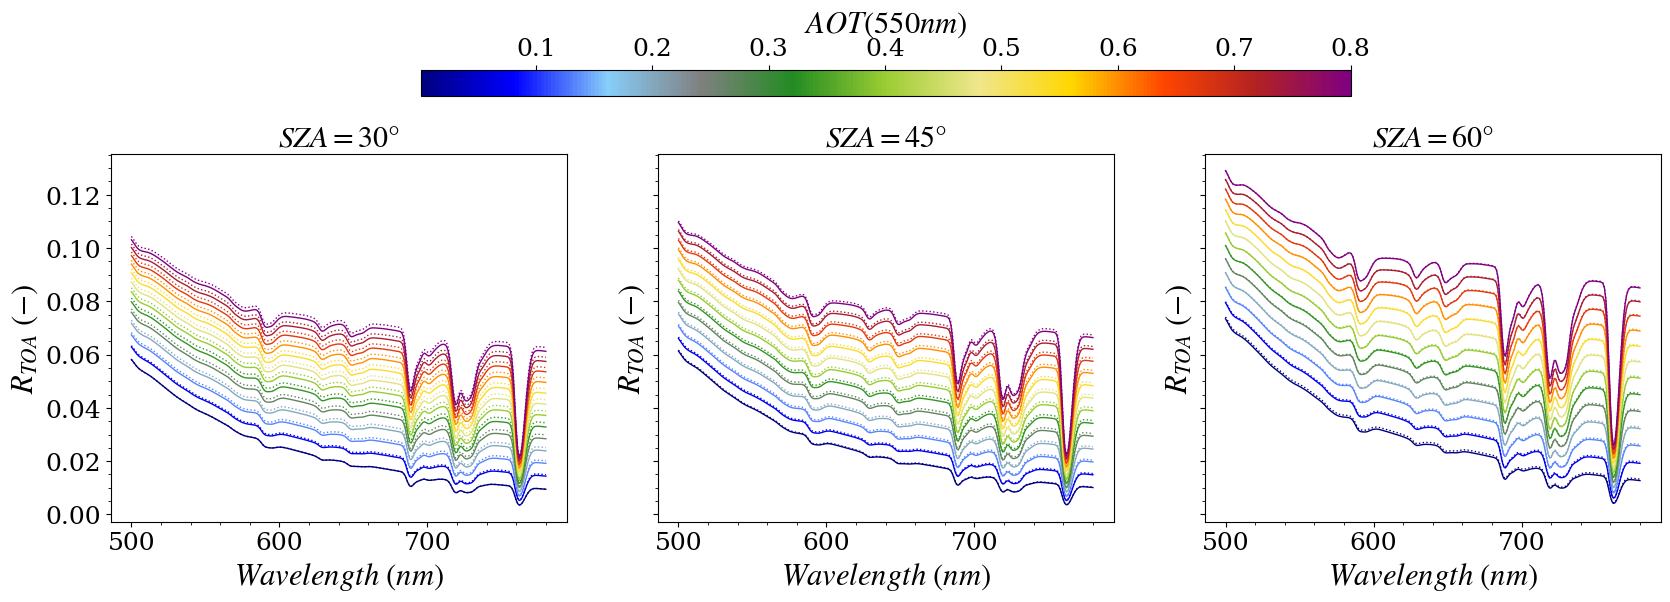

In [15]:


Rtoa=Tg*lut.Rdiff_lut.squeeze()
Rtoa2=Tg*lut2.Rdiff_lut.squeeze()
wl_range=slice(500,780)
cmap = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['navy', "blue", 'lightskyblue',
                                                     "grey",   'forestgreen','yellowgreen',
                                                     "khaki", "gold",
                                                     'orangered', "firebrick", 'purple'])
norm = mpl.colors.Normalize(vmin=0.001,vmax=0.8)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig,axs = plt.subplots(1,3,figsize=(20,6.5),sharey=True)
axs=axs.ravel()

for isza, sza in enumerate(Rtoa.sza.values):
    ax=axs[isza]
    for aot_ref in Rtoa.aot_ref.values[::2]:
        Rtoa_=Rtoa.sel(sza=sza,aot_ref=aot_ref).sel(wl=wl_range) #+ Tabs*Ttot*  np.pi * Rrs
        #Rsim.sel(aot_ref=aot_ref).plot(x='wl',color=cmap(norm(aot_ref)),add_legend=False,ls=':',lw=1,ax=axs[i_])
        Rtoa_.plot(x='wl',color=cmap(norm(aot_ref)),lw=1,ax=ax)
        Rtoa_=Rtoa2.sel(sza=sza,aot_ref=aot_ref).sel(wl=wl_range) #+ Tabs*Ttot*  np.pi * Rrs
       
        Rtoa_.plot(x='wl',color=cmap(norm(aot_ref)),ls=':',lw=1,ax=ax)
    ax.set_title(r'$SZA='+str(sza)+r'\degree$')
    ax.set_ylabel(r'$R_{TOA}\ (-)$')
    ax.set_xlabel(r'$Wavelength\ (nm)$')
    ax.minorticks_on()

cb = fig.colorbar(sm, ax=axs[:], shrink=0.6, aspect=35, pad=0.115, location='top')
cb.set_label(r'$AOT(550nm)$', fontsize=22)